In [1]:
import random
import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm


In [2]:
from mirna_augmentor import *

In [8]:
aug = Augmentor(lim=75)

100%|███████████████████████████████████████████████████████████████████████████| 34721/34721 [01:12<00:00, 477.06it/s]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1720.19it/s]


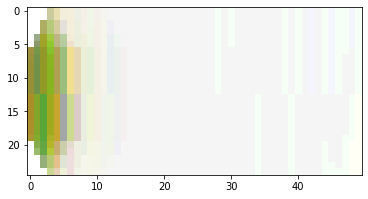

In [9]:
for i in tqdm(range(3000)):
    if aug.loop_seq[i] > 0:
        plt.imshow(aug.loop_images[i,:,:50]*255, alpha=.1)

100%|███████████████████████████████████████████████████████████████████████████| 34721/34721 [00:40<00:00, 864.18it/s]


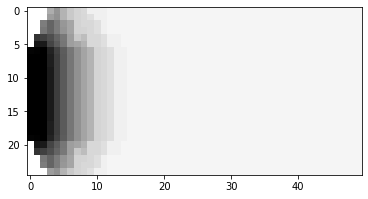

In [11]:
for i in tqdm(range(aug.loop_images_bw.shape[0])):
    if aug.loop_seq[i] > 0:
        plt.imshow(aug.loop_images_bw[i]*255, alpha=.1)

100%|██████████████████████████████████████████████████████████████████████████| 34721/34721 [00:26<00:00, 1295.84it/s]


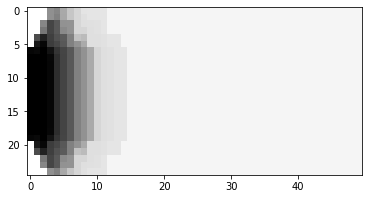

In [13]:
for i in tqdm(range(aug.loop_images_bw.shape[0])):
    if aug.loop_seq[i] > 0 and aug.labels[i]==[1]:
        plt.imshow(aug.loop_images_bw[i]*255, alpha=.1)

100%|██████████████████████████████████████████████████████████████████████████| 34721/34721 [00:08<00:00, 4025.38it/s]


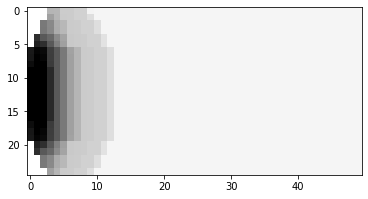

In [14]:
for i in tqdm(range(aug.loop_images_bw.shape[0])):
    if aug.loop_seq[i] > 0 and aug.labels[i]==[0]:
        plt.imshow(aug.loop_images_bw[i]*255, alpha=.1)

In [18]:
shapes = {}
for i in tqdm(range(aug.loop_images.shape[0])):
    if aug.loop_seq[i] > 0:
        shape = aug.loop_images_bw[i]
        if shape.tobytes() in shapes:
            shapes[shape.tobytes()] += 1
        else:
            shapes[shape.tobytes()] = 1

100%|████████████████████████████████████████████████████████████████████████| 34721/34721 [00:00<00:00, 123124.50it/s]


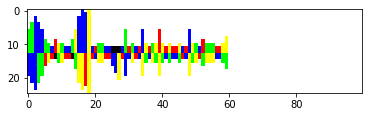

In [59]:
plt.imshow(aug.images[0])

In [71]:
print(aug.top[0])
print(aug.bot[0][5:])
print(aug.loop_seq[0])

UUCCCUUCGAUCCUACCCACGUUCCZZZCUGUCGCAGUAGAGAGGACGCAUCGUUUGGAA
GAGZUAGGZUAAGAGCAAGGCCAGCCAGCAUCAUAUCUCCUGCAUAGUAAACCUU
4


In [74]:
(aug.top[2][::-1] + aug.bot[2][aug.loop_seq[2]+1:]).replace('Z','')

'AAUCUGAACGUUUUAAAGGAAAUAAAAAAGGAAAGACUCAGGGAUAUAAAGCAACAUACACAA'

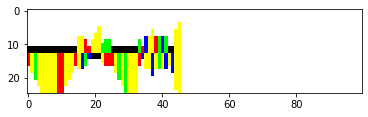

In [61]:
plt.imshow(aug.images[2])

In [58]:
np.min(aug.images[0]*255)

0.0

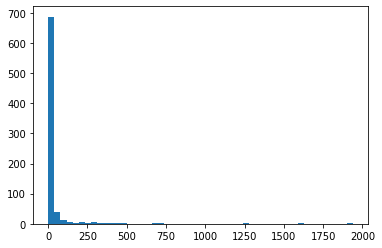

In [21]:
plt.hist(shapes.values(), bins=50);

In [37]:
top_shapes = sorted(shapes, key=shapes.get, reverse=True)[:10]

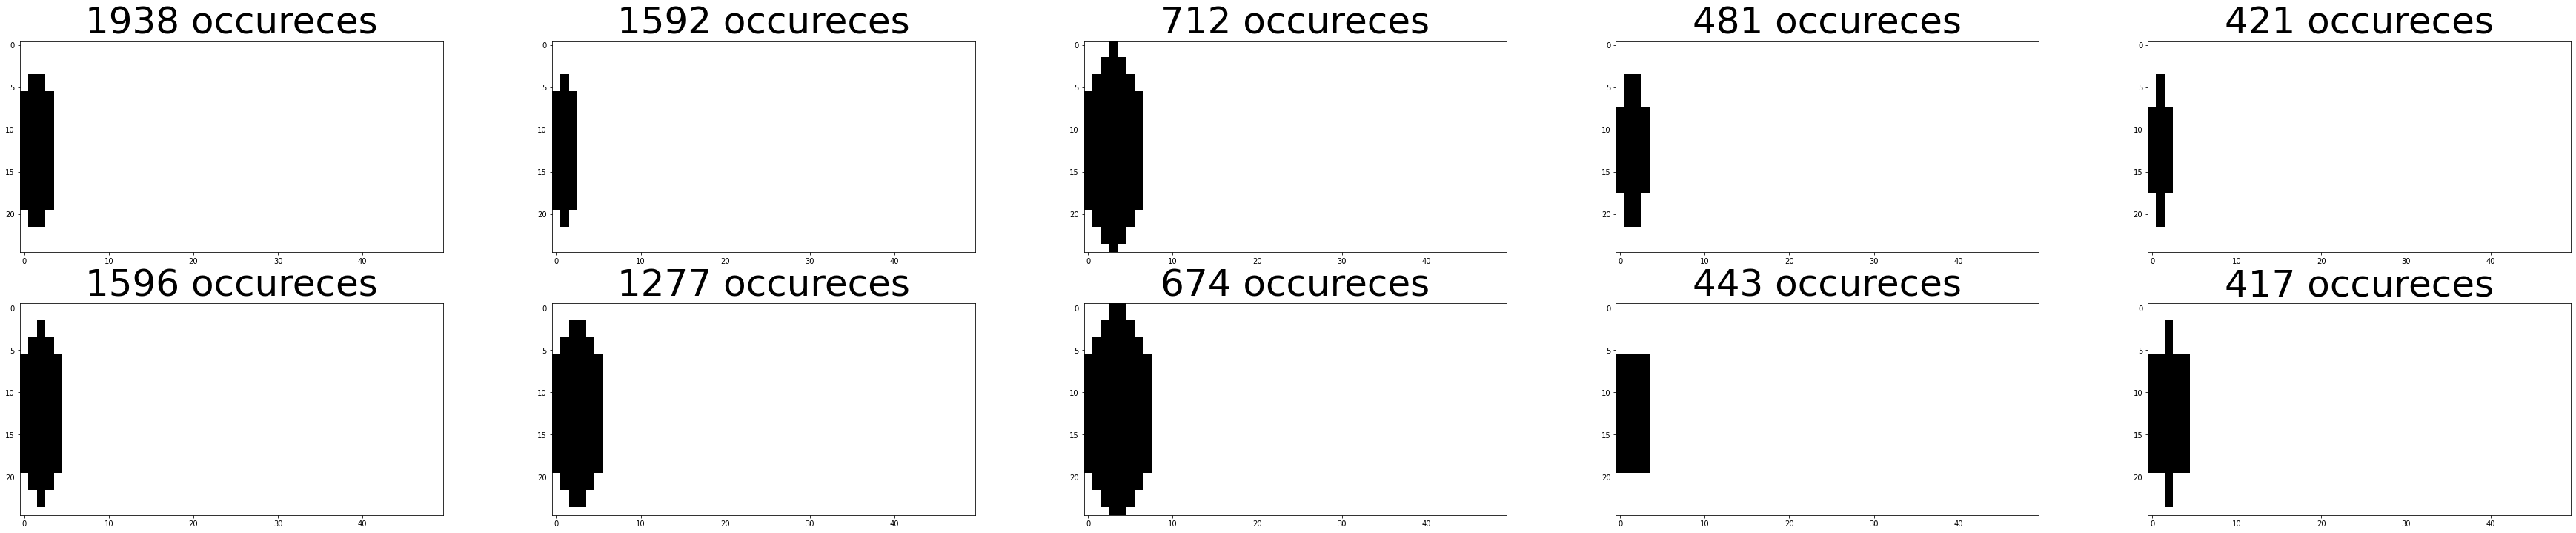

In [52]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(50, 10))

for i in range(len(top_shapes)):
    plot = np.frombuffer(top_shapes[i], dtype = aug.loop_images_bw.dtype).reshape(aug.loop_images_bw[0].shape)
    ax[i%2, i//2, ].imshow(plot*255)
    ax[i%2, i//2].set_title(f'{shapes[top_shapes[i]]} occureces', fontsize=50)
    
fig.tight_layout()

In [ ]:
~np.array([False, True ])

In [ ]:
a = (np.array([1,2,5]) == np.array([3,2,1]))
(~a).sum()

In [ ]:
aug.loop_images.shape

In [ ]:
def compare_loops(tolerance = 5):
    loops = []
    counts = []
    
    for i in tqdm(range(aug.loop_images.shape[0])):
        
        # skip if no loop is present
        if aug.loop_seq[i] == 0:
            continue
            
        
        added = False
        # loop through all current loops
        for j in range(len(loops)):
            should_add = False
            
            # check if the first image is the same
            comp = (loops[j][0] == aug.loop_images[i])
            if comp.all():
                counts[j][0] += 1
                break
            # check if it is similar
            elif (~comp).sum() <= tolerance:
                should_add = True
                
            for k in range(1, len(loops[j])):
                comp = (loops[j][k] == aug.loop_images[i])
                if comp.all():
                    counts[j][k] += 1
                    should_add = False
                    added = True
                    break
                    
            if should_add:
                loops[j].append(aug.loop_images[i])
                counts[j].append(1)
                added = True
            
            if added:
                break
        if not added:
            loops.append([aug.loop_images[i]])
            counts.append([1])
            
    return loops, counts

In [ ]:
l, c = compare_loops()

In [ ]:
c2 = [sum(i) for i in c]

In [ ]:
max(c2)

In [ ]:
shapes = {}
for i in tqdm(range(aug.loop_images.shape[0])):
    if aug.loop_seq[i] > 0:
        shape = np.where(aug.loop_images[i,:,:50] == np.array([1,1,1]), np.array([1,1,1]), np.array([0,0,0]))
        if shape.tobytes() in shapes:
            shapes[shape.tobytes()] += 1
        else:
            shapes[shape.tobytes()] = 1
        
        

In [ ]:
plt.hist(shapes.values(), bins=np.arange(0,124));

In [ ]:
len(shapes.keys())

In [ ]:
max(shapes.values())

In [15]:
mirna = 0
nonmirna = 0
mirna_loop = 0
nonmirna_loop = 0

for i in range(len(aug.loop_seq)):
    if aug.labels[i,0] == 1:
        mirna +=1
        if aug.loop_seq[i] > 0:
            mirna_loop +=1
    else: 
        nonmirna += 1
        if aug.loop_seq[i] > 0:
            nonmirna_loop +=1

In [16]:
aug.loop_str[0], aug.loop_seq[0]

('UUCCC', 4)

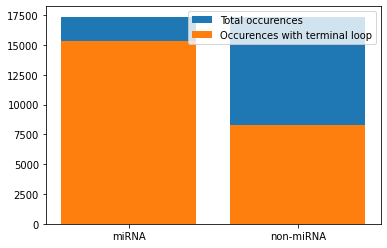

In [17]:
plt.bar([0,1],[mirna, nonmirna], label = 'Total occurences')
plt.bar([0,1],[mirna_loop, nonmirna_loop], label = 'Occurences with terminal loop')
plt.xticks([0, 1],['miRNA','non-miRNA'])
plt.legend();

In [ ]:
plt.hist([i for i in aug.loop_seq if i>0], bins=np.arange(0,76));

In [ ]:
aug.labels

In [ ]:
plt.hist()

In [ ]:
plt.imshow(aug.augment_mirna(0))

In [ ]:
plt.imshow(aug.images[0])

In [ ]:
aug.generate_augmented_mirna('newrna/augmentor_default_3/', 10)

In [ ]:
newrna = np.load('newrna/augmentor_default_3/new_mirna_data.npy')

In [ ]:
plt.imshow(newrna[51124]*255)

In [ ]:
link = 'D:/users/Marko/downloads/mirna/'

In [ ]:
images = np.load(f'{link}/data/modmirbase_train_images.npz')['arr_0']/255

In [ ]:
x_len = np.load(f'{link}/data/modmirbase_train_images_len.npz')
x_bar = np.load(f'{link}/data/modmirbase_train_images_bar.npz')

In [ ]:
x_len_max = np.argmax(x_len, 1)

In [ ]:
x_bar_max = np.argmax(x_bar, 1)

In [ ]:
length_table = {('A','U'):2,('U','A'):2,('C','G'):1,
                    ('G','C'):1,('G','U'):3,('U','G'):3,
                    ('A','A'):4,('A','G'):4,('A','C'):4,
                    ('C','C'):4,('C','U'):4,('C','A'):4,
                    ('U','C'):4,('U','U'):4,('G','A'):4,
                    ('G','G'):1,('A','Z'):1,('Z','A'):1,
                    ('U','Z'):1,('Z','U'):1,('C','Z'):1,
                    ('Z','C'):1,('G','Z'):1,('Z','G'):1,
                    ('Z','Z'):1}

In [ ]:
plt.hist(x_bar_max.flatten(), bins = np.arange(0,14,1));

In [ ]:
plt.hist(x_len_max, bins=np.arange(0,101,1));

In [ ]:
def get_color(pixel):
    """
    returns the encoded value for a pixel
    """
    if (pixel == np.array([0,0,0])).all():  
        return 'Z' # black
    elif (pixel == np.array([1,0,0])).all():  
        return 'G' # red
    elif (pixel == np.array([0,0,1])).all():  
        return 'C' # blue
    elif (pixel == np.array([0,1,0])).all():  
        return 'U' # green
    elif (pixel == np.array([1,1,0])).all():  
        return 'A' # yellow
    else:
        print("Something wrong!")

In [ ]:
def get_pixel(color):
    """
    returns the encoded value for a pixel
    """
    if color == 'Z': 
        return np.array([0,0,0])
    elif color == 'G':
        return np.array([1,0,0])
    elif color == 'C':
        return np.array([0,0,1])
    elif color == 'U': 
        return np.array([0,1,0])
    elif color == 'A':
        return np.array([1,1,0])
    else:
        print("Something wrong!")

In [ ]:
top = []
bot = []
top_bonds = []
bot_bonds = []
for i in tqdm(range(images.shape[0])):
    topstr=''
    botstr=''
    top_bond = []
    bot_bond = []
    for j in range(x_len_max[i]+1):
        top_col = get_color(images[i,12,j])
        bot_col = get_color(images[i,13,j])

        topstr+=top_col
        botstr+=bot_col
        
        if top_col == 'Z':
            top_bond.append('-')
        elif x_bar_max[i, 2*j] == length_table[top_col, bot_col]:
            top_bond.append('|')
        else:
            top_bond.append('.')
        
        if bot_col == 'Z':
            bot_bond.append('-')
        elif x_bar_max[i, 1+2*j] == length_table[top_col, bot_col]:
            bot_bond.append('|')
        else:
            bot_bond.append('.')
    top.append(topstr)
    bot.append(botstr)
    top_bonds.append(top_bond)
    bot_bonds.append(bot_bond)

In [ ]:
def swap_nucleotides(top, bot, top_bond, bot_bond, lent, prob=.2):
    for i in range(8,lent):
        if np.random.uniform() < prob:
            top[i], bot[i] = bot[i],top[i]
            top_bond[i], bot_bond[i] = bot_bond[i], top_bond[i]
    
    return top, bot, top_bond, bot_bond

In [ ]:
def change_gap(top, bot, top_bond, bot_bond, lent, prob_fill=.2, prob_remove=.2):
    for i in range(8,lent):
        if top[i] != 'Z' and bot[i] != 'Z':
            if np.random.uniform() < prob_remove:
                if np.random.uniform() < .5:
                    top[i] = "Z"
                    top_bond[i] = '-'
                    bot_bond[i] = '.'
                else:
                    bot[i] = "Z"
                    top_bond[i] = '.'
                    bot_bond[i] = '-'

        else:
            if top[i] == "Z" and np.random.uniform() < prob_fill:
                top[i] = get_matching_color(bot[i])
                # we are getting a matching color -> always results in good bond
                top_bond[i] = '|'
                bot_bond[i] = '|'

            if bot[i] == "Z" and np.random.uniform() < prob_fill:
                bot[i] = get_matching_color(top[i])
                top_bond[i] = '|'
                bot_bond[i] = '|'
    return top, bot, top_bond, bot_bond

In [ ]:
def change_bond(top, bot, top_bond, bot_bond, lent, prob_make_strong=.1, prob_make_weak=.1):
    for i in range(8, lent):
        if is_strong_bond(top[i],bot[i]):
            if np.random.uniform() < prob_make_weak:
                top[i], bot[i] = get_weak_bond()
                top_bond[i] = '.'
                bot_bond[i] = '.'
        else:
            if np.random.uniform() < prob_make_strong:
                top[i], bot[i] = get_strong_bond()
                top_bond[i] = '|'
                bot_bond[i] = '|'
    return top, bot, top_bond, bot_bond

In [ ]:
def mix_chunks(top, bot, top_bond, bot_bond, lent, prob=.3, prob_reverse=.3,chunk_length=9):
    chunks = []
    chunk_idx = np.arange((lent-8)//chunk_length+1)
    shuffle_list=[]
    shuffle_dict={}
    
    for i in chunk_idx:
        shuffle_dict[i] = i
        if np.random.uniform()<prob_reverse:
            chunks.append(np.arange(8+i*chunk_length, min(8+(i+1)*chunk_length, lent+1))[::-1])
        else:
            chunks.append(np.arange(8+i*chunk_length, min(8+(i+1)*chunk_length, lent+1)))
        if np.random.uniform()<prob:
            shuffle_list.append(i)
    shuf = shuffle_list.copy()
    random.shuffle(shuf)
    
    for i in range(len(shuffle_list)):
        shuffle_dict[shuffle_list[i]] = shuf[i] 
    
    chunks = [chunks[i] for i in shuffle_dict.values()]
    
    order = [i for i in range(8)]+[i for item in chunks for i in item]
    print(len(order), len(top))
    top = [top[i] for i in order]
    bot = [bot[i] for i in order]
    
    top_bond = [top_bond[i] for i in order]
    bot_bond = [bot_bond[i] for i in order]
    return top, bot, top_bond, bot_bond

In [ ]:
def get_matching_color(nt):
    if nt == 'A':
        return 'U'
    if nt == 'U':
        return np.random.choice(['A','G'], p=[.7,.3])
    if nt == 'C':
        return 'G'
    if nt == 'G':
        return np.random.choice(['C','U'], p=[.8,.2])
    if nt == 'Z':
        return 'Z'

In [ ]:
def is_strong_bond(nt1, nt2):
    if (nt1 == 'A' and nt2 == 'U') or (nt1 == 'U' and nt2 == 'A'):
        return True
    elif (nt1 == 'C' and nt2 == 'G') or (nt1 == 'G' and nt2 == 'C'):
        return True
    elif (nt1 == 'U' and nt2 == 'G') or (nt1 == 'G' and nt2 == 'U'):
        return True
    else:
        return False

In [ ]:
def get_weak_bond():
    choices = [('A','A'),('A','G'),('A','C'),('C','C'),('C','U'),('C','A'),('U','C'),('U','U'),('G','A'),('G','G')]
    return choices[np.random.choice(len(choices))]

In [ ]:
def get_strong_bond():
    choices = [('A','U'),('U','A'),('C','G'),('G','C'),('G','U'),('U','G')]
    return choices[np.random.choice(len(choices))]

In [ ]:
def reconstruct_image(top, bot, top_bond, bot_bond, rna_length):

    image = np.ones((25,100,3))
    for i in range(len(top)):
        lnt = length_table[(top[i],bot[i])]
        
        lnt_top = calc_length(top, bot, top_bond, bot_bond, lnt, i, 'top', rna_length)
        lnt_bot = calc_length(top, bot, top_bond, bot_bond, lnt, i, 'bot', rna_length)
        
        
        image[max(12-lnt_top,0):13,i] = get_pixel(top[i])
        image[13:min(13+lnt_bot+1,25),i] = get_pixel(bot[i])
    return image
    
    

In [ ]:
def calc_length(top, bot, top_bond, bot_bond, lnt, pos, strand, rna_length):
    if strand == 'top':
        strand = top_bond
    else:
        strand = bot_bond

    if strand[pos] == '.':
        tr = pos - 1
        tl = pos + 1


        
        while tr >= 0 and strand[tr] == '.':
            tr -= 1
        while tl <= rna_length and strand[tl] =='.':
            tl += 1

        dots = tr+tl+1
        mid = dots/2
        p = pos - tr

        if p > mid:
            k = dots+1
            while k > p:
                lnt += 2
                k -= 1
        else:
            k = 1
            while k <= p:
                lnt += 2
                k += 1
    return lnt

In [ ]:
images.dtype

In [ ]:
plt.imshow(reconstruct_image(top[110], bot[110], top_bonds[110], bot_bonds[110],  x_len_max[110]))

In [ ]:
plt.imshow(augment_mirna(10))

In [ ]:
plt.imshow(images[10])

In [ ]:
print(top_bonds[10][-10:]), print(bot_bonds[10][-10:])

In [ ]:
def augment_mirna(idx):
    lent = x_len_max[idx]
    tn = list(top[idx])
    bn = list(bot[idx])
    tb = top_bonds[idx].copy()
    bb = bot_bonds[idx].copy()
    
    tn,bn,tb,bb = swap_nucleotides(tn,bn,tb,bb,lent)
    tn,bn,tb,bb = change_gap(tn,bn,tb,bb,lent)
    tn,bn,tb,bb = change_bond(tn,bn,tb,bb,lent)
    tn,bn,tb,bb = mix_chunks(tn,bn,tb,bb,lent)
    rec = reconstruct_image(tn,bn,tb,bb,lent)
    
    return rec

In [ ]:
print(top[0])
print(bot[0])

lent = x_len_max[0]

tn, bn = swap_nucleotides(list(top[0]),list(bot[0]),top_bonds,lent,0.2)
tn, bn = change_gap(tn,bn,lent,0.2)
tn, bn = change_bond(tn,bn,lent,0.15)
print("".join(tn))
print("".join(bn))

In [ ]:
weird = images[(x_len_max == 99)]

In [ ]:
#x_len[(x_len_max == 0)][0]

In [ ]:
plt.imshow(weird[0])